# Linear Statics of 3d Solids

In [1]:
# input data
size = Lx, Ly, Lz = (20, 2, 2)
F = -10  # value of the load at the free end
E = 12000.0  # Young's mpdulus
nu = 0.0  # Poisson's ratio
F * Lx**3 / (3 * E * Ly * Lz**3 / 12)

-1.6666666666666667

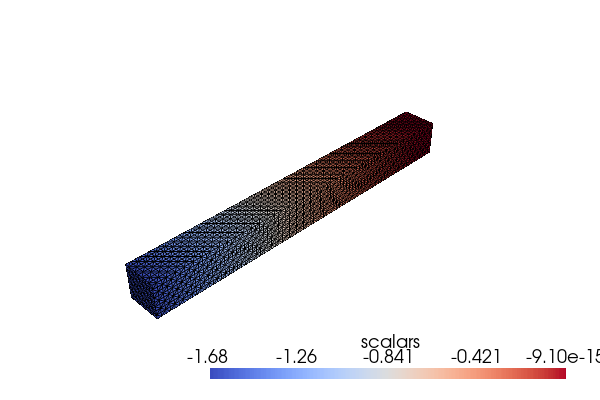

In [2]:
from neumann import repeat
from polymesh.grid import gridH8 as grid
from polymesh.utils.topology import H8_to_H27
from polymesh.space import PointCloud, StandardFrame
from sigmaepsilon import Structure, PointData, SolidMesh
from sigmaepsilon.fem.cells import H8, H27
import numpy as np

# generate grid
gridparams = {"size": size, "shape": (40, 4, 4)}
coords, topo = grid(**gridparams)

# place the origo to the center of the cross section
# at the support
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0.0, 0.0]))
coords = pc.show()
coords, topo = H8_to_H27(coords, topo)

# istoropic material
hooke = np.array(
    [
        [1, nu, nu, 0, 0, 0],
        [nu, 1, nu, 0, 0, 0],
        [nu, nu, 1, 0, 0, 0],
        [0.0, 0, 0, (1 - nu) / 2, 0, 0],
        [0.0, 0, 0, 0, (1 - nu) / 2, 0],
        [0.0, 0, 0, 0, 0, (1 - nu) / 2],
    ]
) * (E / (1 - nu**2))

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, 3:] = True

# unit vertical load at (Lx, 0, 0)
iF = pc.index_of_closest([Lx, 0.0, 0.0])
loads = np.zeros((coords.shape[0], 3))
loads[iF, 2] = F

# pointdata
GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)

# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cells = H27(topo=topo, frames=frames, material=hooke)

# set up mesh and structure
mesh = SolidMesh(pd, cells, frame=GlobalFrame)
structure = Structure(mesh=mesh)

# solve
structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()

# plot
structure.mesh.pd["scalars"] = dofsol[:, 2]
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap="coolwarm",
    jupyter_backend="static",
    scalars="scalars",
    theme="document",
)

In [3]:
from neumann import atleast2d
from sigmaepsilon.utils.material.hmh import HMH_3d_v

p = atleast2d(H8.lcenter(), front=True)
forces = cells.internal_forces(points=p, target="global")
hmh = HMH_3d_v(*[forces[:, i] for i in range(6)])
mesh.config["pyvista", "plot", "show_edges"] = True
# mesh.config['pyvista', 'plot', 'scalars'] = forces[:, 0]
mesh.config["pyvista", "plot", "scalars"] = hmh

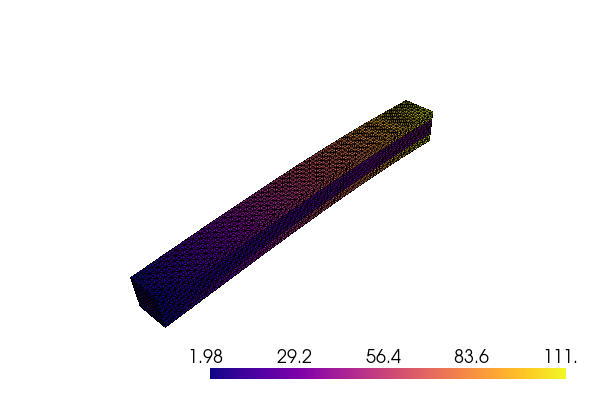

In [4]:
mesh.pd.x = mesh.pd.x + dofsol[:, :3]
cmap = ["blue", "purple", "green", "yellow", "orange", "red"]
cmap = "plasma"
mesh.pvplot(
    notebook=True,
    jupyter_backend="static",
    cmap=cmap,
    window_size=(600, 400),
    config_key=["pyvista", "plot"],
    theme="document",
)

In [5]:
import pyvista as pv

pl = pv.Plotter(notebook=False, theme=pv.themes.DocumentTheme())
mesh.plot(
    plotter=pl,
    cmap=cmap,
    config_key=["pyvista", "plot"],
)

In [6]:
shape = (3, 10, 4, 5)
shape[1:-2]

(10,)